In [19]:
import numpy as np
from keras import layers, models, optimizers
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, concatenate, Dropout, Dense, Flatten, Reshape
from keras import backend as K
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from utils import combine_images
from PIL import Image
from capsulelayers import CapsuleLayer, PrimaryCap, Length, Mask
import os
import argparse
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
import cv2
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG


def margin_loss(y_true, y_pred):
    """
    Margin loss for Eq.(4). When y_true[i, :] contains not just one `1`, this loss should work too. Not test it.
    :param y_true: [None, n_classes]
    :param y_pred: [None, num_capsule]
    :return: a scalar loss value.
    """
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

In [152]:
inp = Input(shape=(64,64,3))
conv1 = Conv2D(kernel_size=(3,3), filters=16, activation='tanh', strides=(2,2), padding='same')(inp)
conv1 = Dropout(0.5)(conv1)
conv2 = Conv2D(kernel_size=(3,3), filters=32, activation='tanh', strides=(2,2), padding='same')(conv1)
conv2 = Dropout(0.5)(conv2)
flatt = Flatten()(conv2)
featModel = Model(inputs=[inp], outputs=[flatt],name='featModel')
featModel.summary()

leftInp  = Input(shape=(64,64,3))
rightInp = Input(shape=(64,64,3))
leftFeat = featModel(leftInp)
rightFeat = featModel(rightInp)

concat = concatenate([leftFeat, rightFeat], name='concat')
baseModel = Model(inputs=[leftInp,rightInp],outputs=[concat])
baseModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 32, 32, 16)        448       
_________________________________________________________________
dropout_15 (Dropout)         (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
dropout_16 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 8192)              0         
Total params: 5,088
Trainable params: 5,088
Non-trainable params: 0
_________________________________________________________________
________

In [153]:
leftInp  = Input(shape=(64,64,3), name='leftinput')
rightInp = Input(shape=(64,64,3), name='rightinput')
leftFeat = featModel(leftInp)
rightFeat = featModel(rightInp)

concat = concatenate([leftFeat, rightFeat], name='concat')
baseModel = Model(inputs=[leftInp,rightInp],outputs=[concat])
baseModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
leftinput (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
rightinput (InputLayer)         (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
featModel (Model)               (None, 8192)         5088        leftinput[0][0]                  
                                                                 rightinput[0][0]                 
__________________________________________________________________________________________________
concat (Concatenate)            (None, 16384)        0           featModel[3][0]                  
          

In [154]:
n_class = 2
routings = 3
x = baseModel.get_layer('concat').output
# f = Flatten()
# r = Flatten()(x)
r = Dropout(0.8)(x)
out = Dense(2, activation='softmax')(r)
# x = layers.Input(shape=input_shape)

# Layer 1: Just a conventional Conv2D layer
# conv1 = layers.Conv2D(filters=256, kernel_size=9, strides=1, padding='valid', activation='relu', name='conv1')(x)

#     output = layers.Conv2D(filters=8*32, kernel_size=9, strides=2, padding='valid',
#                            name='primarycap_conv2d')(conv1)

# # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_capsule, dim_capsule]
# primarycaps = PrimaryCap(x, dim_capsule=8, n_channels=32, kernel_size=9, strides=2, padding='valid')

# # Layer 3: Capsule layer. Routing algorithm works here.
# digitcaps = CapsuleLayer(num_capsule=n_class, dim_capsule=16, routings=routings,
#                          name='digitcaps')(primarycaps)

# # Layer 4: This is an auxiliary layer to replace each capsule with its length. Just to match the true label's shape.
# # If using tensorflow, this will not be necessary. :)
# out_caps = Length(name='capsnet')(digitcaps)


In [155]:
model = Model(inputs=baseModel.inputs,outputs=[out])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
leftinput (InputLayer)          (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
rightinput (InputLayer)         (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
featModel (Model)               (None, 8192)         5088        leftinput[0][0]                  
                                                                 rightinput[0][0]                 
__________________________________________________________________________________________________
concat (Concatenate)            (None, 16384)        0           featModel[3][0]                  
          

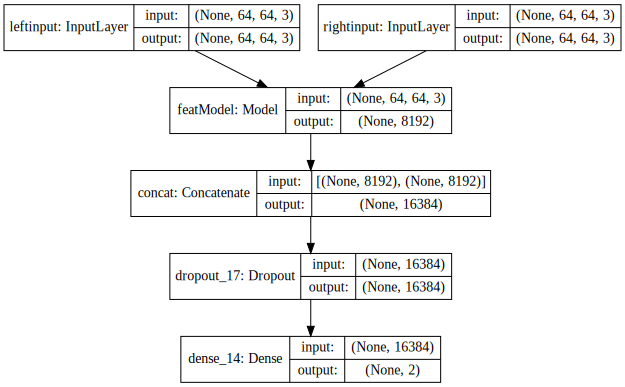

In [156]:
model.compile(optimizer=optimizers.Adam(lr=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [116]:
import pandas as pd
from keras.utils import to_categorical
df_train = pd.read_csv('seen-dataset/dataset_seen_training_siamese.csv')
df_val = pd.read_csv('seen-dataset/dataset_seen_validation_siamese.csv')
df_val.shape

(924, 4)

In [157]:
def datagen(parentpath = '../partition-80-20-dataset/TrainingSet/', batchsize = 16, mode='train'):
    counter = 0
    while True:
        counter=0
        leftinputs=[]
        rightinputs=[]
        classes=[]
        while counter < batchsize:
            leftpath = ''
            rightpath = ''
            cls = None
            if mode == 'train':
                index = np.random.randint(df_train.shape[0])
                leftpath = os.path.join(parentpath,df_train.iloc[index]['left'])
                rightpath = os.path.join(parentpath,df_train.iloc[index]['right'])
                cls = int(df_train.iloc[index]['label'])
            elif mode == 'val':
                index = np.random.randint(df_val.shape[0])
                leftpath = os.path.join(parentpath,df_val.iloc[index]['left'])
                rightpath = os.path.join(parentpath,df_val.iloc[index]['right'])
                cls = int(df_val.iloc[index]['label'])
#             print(cls)

#             leftimg = cv2.cvtColor(cv2.imread(leftpath), cv2.COLOR_BGR2GRAY)
            leftimg = cv2.imread(leftpath,1)
            leftimg = (255 - leftimg) / 255

#             rightimg = cv2.cvtColor(cv2.imread(rightpath), cv2.COLOR_BGR2GRAY)
            rightimg = cv2.imread(rightpath,1)
            rightimg = (255 - rightimg) / 255

#                 leftimg =np.expand_dims(255.0-cv2.imread(leftpath,0),-1)/255.0
#                 rightimg =np.expand_dims(255.0-cv2.imread(rightpath,0),-1)/255.0
            leftinputs.append(leftimg)
            rightinputs.append(rightimg)
            classes.append(cls)
            counter+=1
#         except Exception as ex:
# #             pass
#             print('leftpath:',leftpath,',rightpath:',rightpath,',class:',cls)
        
        yield [np.array(leftinputs),np.array(rightinputs)], to_categorical(classes,num_classes=2)

In [158]:
batchsize=16
tg = datagen(parentpath='seen-dataset/TrainingSet/',batchsize=batchsize,mode='train')
vg = datagen(parentpath='seen-dataset/ValidationSet/',batchsize=batchsize,mode='val')

In [159]:
x, y = next(vg)

In [160]:
EPOCHS = 1000
tb = callbacks.TensorBoard(log_dir='store/tensorboard-logs',
                               batch_size=16)
hist = model.fit_generator(generator=tg
                    ,validation_data=vg
                    ,epochs=EPOCHS
                    , steps_per_epoch=1
                    , validation_steps=1
                    , callbacks=[tb])

Epoch 1/1000
1/1 [==============================] - 0s 419ms/step - loss: 0.7625 - acc: 0.5625 - val_loss: 0.7319 - val_acc: 0.2500
Epoch 2/1000
1/1 [==============================] - 0s 14ms/step - loss: 0.8472 - acc: 0.4375 - val_loss: 0.7375 - val_acc: 0.2500
Epoch 3/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.7941 - acc: 0.3750 - val_loss: 0.7462 - val_acc: 0.3750
Epoch 4/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.6935 - acc: 0.6875 - val_loss: 0.7317 - val_acc: 0.2500
Epoch 5/1000
1/1 [==============================] - 0s 13ms/step - loss: 0.6417 - acc: 0.5625 - val_loss: 0.7067 - val_acc: 0.3750
Epoch 6/1000
1/1 [==============================] - 0s 10ms/step - loss: 0.8871 - acc: 0.4375 - val_loss: 0.6894 - val_acc: 0.5625
Epoch 7/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.6507 - acc: 0.6875 - val_loss: 0.7340 - val_acc: 0.3750
Epoch 8/1000
1/1 [==============================] - 0s 11ms/step - loss: 0.5554 - 

Epoch 64/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.7827 - acc: 0.5000 - val_loss: 0.7111 - val_acc: 0.4375
Epoch 65/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.6595 - acc: 0.6250 - val_loss: 0.7320 - val_acc: 0.4375
Epoch 66/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.6564 - acc: 0.6250 - val_loss: 0.7397 - val_acc: 0.4375
Epoch 67/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.6294 - acc: 0.6875 - val_loss: 0.7518 - val_acc: 0.3750
Epoch 68/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.6053 - acc: 0.5625 - val_loss: 0.6939 - val_acc: 0.6250
Epoch 69/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.5861 - acc: 0.6875 - val_loss: 0.7543 - val_acc: 0.3125
Epoch 70/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.7650 - acc: 0.4375 - val_loss: 0.6808 - val_acc: 0.6250
Epoch 71/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.

Epoch 126/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.4028 - acc: 0.8125 - val_loss: 0.7791 - val_acc: 0.4375
Epoch 127/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.5797 - acc: 0.6250 - val_loss: 0.7951 - val_acc: 0.4375
Epoch 128/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.6919 - acc: 0.5625 - val_loss: 0.8195 - val_acc: 0.2500
Epoch 129/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.6072 - acc: 0.6250 - val_loss: 0.8161 - val_acc: 0.3125
Epoch 130/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.4831 - acc: 0.8125 - val_loss: 0.7839 - val_acc: 0.3750
Epoch 131/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.4727 - acc: 0.8750 - val_loss: 0.8068 - val_acc: 0.3750
Epoch 132/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.5690 - acc: 0.6875 - val_loss: 0.7365 - val_acc: 0.5000
Epoch 133/1000
1/1 [==============================] - 0s 40ms/step - 

Epoch 188/1000
1/1 [==============================] - 0s 29ms/step - loss: 0.6162 - acc: 0.6250 - val_loss: 0.7295 - val_acc: 0.6250
Epoch 189/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.4791 - acc: 0.8750 - val_loss: 0.7032 - val_acc: 0.6250
Epoch 190/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.5369 - acc: 0.6875 - val_loss: 0.9193 - val_acc: 0.3750
Epoch 191/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.4417 - acc: 0.8125 - val_loss: 0.8484 - val_acc: 0.4375
Epoch 192/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.5719 - acc: 0.7500 - val_loss: 0.9665 - val_acc: 0.3125
Epoch 193/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.4609 - acc: 0.8750 - val_loss: 0.8611 - val_acc: 0.4375
Epoch 194/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.4413 - acc: 0.9375 - val_loss: 0.8525 - val_acc: 0.4375
Epoch 195/1000
1/1 [==============================] - 0s 30ms/step - 

Epoch 250/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.5275 - acc: 0.7500 - val_loss: 0.6773 - val_acc: 0.6875
Epoch 251/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.5467 - acc: 0.8125 - val_loss: 0.9024 - val_acc: 0.4375
Epoch 252/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.6064 - acc: 0.6250 - val_loss: 0.7355 - val_acc: 0.6875
Epoch 253/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.4938 - acc: 0.7500 - val_loss: 0.9631 - val_acc: 0.4375
Epoch 254/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.5033 - acc: 0.7500 - val_loss: 0.7197 - val_acc: 0.6250
Epoch 255/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.5296 - acc: 0.6875 - val_loss: 0.9562 - val_acc: 0.4375
Epoch 256/1000
1/1 [==============================] - 0s 25ms/step - loss: 0.3897 - acc: 0.9375 - val_loss: 0.9012 - val_acc: 0.4375
Epoch 257/1000
1/1 [==============================] - 0s 35ms/step - 

Epoch 312/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.6315 - acc: 0.5625 - val_loss: 1.0093 - val_acc: 0.4375
Epoch 313/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3776 - acc: 0.9375 - val_loss: 0.7617 - val_acc: 0.6250
Epoch 314/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.4472 - acc: 0.9375 - val_loss: 0.7500 - val_acc: 0.6250
Epoch 315/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.4775 - acc: 0.7500 - val_loss: 1.0637 - val_acc: 0.3750
Epoch 316/1000
1/1 [==============================] - 0s 28ms/step - loss: 0.5595 - acc: 0.6875 - val_loss: 1.0710 - val_acc: 0.3750
Epoch 317/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.5265 - acc: 0.8125 - val_loss: 0.6511 - val_acc: 0.6875
Epoch 318/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.4894 - acc: 0.6875 - val_loss: 0.9085 - val_acc: 0.5625
Epoch 319/1000
1/1 [==============================] - 0s 38ms/step - 

Epoch 374/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.4045 - acc: 0.9375 - val_loss: 0.9189 - val_acc: 0.5625
Epoch 375/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.2944 - acc: 0.9375 - val_loss: 0.8221 - val_acc: 0.6250
Epoch 376/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3916 - acc: 0.8750 - val_loss: 0.9420 - val_acc: 0.5625
Epoch 377/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.4053 - acc: 0.8125 - val_loss: 1.4852 - val_acc: 0.1875
Epoch 378/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.2708 - acc: 0.9375 - val_loss: 0.9463 - val_acc: 0.5000
Epoch 379/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.4014 - acc: 0.7500 - val_loss: 1.0150 - val_acc: 0.5000
Epoch 380/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.2703 - acc: 1.0000 - val_loss: 0.9480 - val_acc: 0.5625
Epoch 381/1000
1/1 [==============================] - 0s 30ms/step - 

Epoch 436/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.3912 - acc: 0.8750 - val_loss: 1.0068 - val_acc: 0.5000
Epoch 437/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3413 - acc: 0.8125 - val_loss: 0.6539 - val_acc: 0.7500
Epoch 438/1000
1/1 [==============================] - 0s 29ms/step - loss: 0.3799 - acc: 0.8750 - val_loss: 1.1264 - val_acc: 0.4375
Epoch 439/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.2939 - acc: 0.9375 - val_loss: 1.0436 - val_acc: 0.5000
Epoch 440/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.2958 - acc: 0.9375 - val_loss: 0.9985 - val_acc: 0.5000
Epoch 441/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.3363 - acc: 0.9375 - val_loss: 0.9356 - val_acc: 0.5625
Epoch 442/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.3653 - acc: 0.9375 - val_loss: 0.8484 - val_acc: 0.6875
Epoch 443/1000
1/1 [==============================] - 0s 37ms/step - 

Epoch 498/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.2812 - acc: 0.9375 - val_loss: 1.2275 - val_acc: 0.4375
Epoch 499/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.2734 - acc: 0.9375 - val_loss: 1.2836 - val_acc: 0.4375
Epoch 500/1000
1/1 [==============================] - 0s 26ms/step - loss: 0.3753 - acc: 0.7500 - val_loss: 1.2336 - val_acc: 0.4375
Epoch 501/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.2158 - acc: 1.0000 - val_loss: 1.4085 - val_acc: 0.3750
Epoch 502/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.3321 - acc: 0.8750 - val_loss: 1.1901 - val_acc: 0.5000
Epoch 503/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.4522 - acc: 0.8750 - val_loss: 1.7867 - val_acc: 0.1875
Epoch 504/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.2267 - acc: 0.9375 - val_loss: 0.9345 - val_acc: 0.6250
Epoch 505/1000
1/1 [==============================] - 0s 35ms/step - 

Epoch 560/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.2486 - acc: 1.0000 - val_loss: 0.8981 - val_acc: 0.6875
Epoch 561/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.2966 - acc: 0.8750 - val_loss: 0.9999 - val_acc: 0.6250
Epoch 562/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.2612 - acc: 1.0000 - val_loss: 1.3792 - val_acc: 0.4375
Epoch 563/1000
1/1 [==============================] - 0s 29ms/step - loss: 0.3563 - acc: 0.9375 - val_loss: 1.0382 - val_acc: 0.6250
Epoch 564/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.2698 - acc: 0.9375 - val_loss: 1.0176 - val_acc: 0.6250
Epoch 565/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.1876 - acc: 1.0000 - val_loss: 0.9762 - val_acc: 0.6875
Epoch 566/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.2070 - acc: 1.0000 - val_loss: 1.6284 - val_acc: 0.3750
Epoch 567/1000
1/1 [==============================] - 0s 30ms/step - 

Epoch 622/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.2212 - acc: 1.0000 - val_loss: 0.7919 - val_acc: 0.7500
Epoch 623/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.1776 - acc: 0.9375 - val_loss: 1.3092 - val_acc: 0.5000
Epoch 624/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.1731 - acc: 1.0000 - val_loss: 1.3241 - val_acc: 0.5000
Epoch 625/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.2696 - acc: 0.8750 - val_loss: 1.7809 - val_acc: 0.3125
Epoch 626/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.2756 - acc: 0.8750 - val_loss: 1.0597 - val_acc: 0.6250
Epoch 627/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.3553 - acc: 0.8125 - val_loss: 1.0544 - val_acc: 0.6250
Epoch 628/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.2777 - acc: 0.8750 - val_loss: 1.6226 - val_acc: 0.3750
Epoch 629/1000
1/1 [==============================] - 0s 39ms/step - 

Epoch 684/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.2581 - acc: 0.9375 - val_loss: 1.9723 - val_acc: 0.3125
Epoch 685/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.2296 - acc: 0.9375 - val_loss: 1.5065 - val_acc: 0.5000
Epoch 686/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.2498 - acc: 0.8750 - val_loss: 1.8276 - val_acc: 0.3750
Epoch 687/1000
1/1 [==============================] - 0s 39ms/step - loss: 0.2829 - acc: 0.8750 - val_loss: 1.9946 - val_acc: 0.3125
Epoch 688/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.1577 - acc: 1.0000 - val_loss: 1.5383 - val_acc: 0.4375
Epoch 689/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.2880 - acc: 0.9375 - val_loss: 0.6579 - val_acc: 0.8125
Epoch 690/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.1500 - acc: 1.0000 - val_loss: 0.6897 - val_acc: 0.8125
Epoch 691/1000
1/1 [==============================] - 0s 37ms/step - 

Epoch 746/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.2007 - acc: 0.8750 - val_loss: 1.2595 - val_acc: 0.6250
Epoch 747/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.1014 - acc: 1.0000 - val_loss: 2.2024 - val_acc: 0.3125
Epoch 748/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.2355 - acc: 0.8750 - val_loss: 2.0498 - val_acc: 0.3750
Epoch 749/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.2319 - acc: 1.0000 - val_loss: 1.6376 - val_acc: 0.5000
Epoch 750/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.1738 - acc: 1.0000 - val_loss: 1.8264 - val_acc: 0.4375
Epoch 751/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.2721 - acc: 0.9375 - val_loss: 1.8857 - val_acc: 0.4375
Epoch 752/1000
1/1 [==============================] - 0s 41ms/step - loss: 0.1211 - acc: 1.0000 - val_loss: 1.6603 - val_acc: 0.5000
Epoch 753/1000
1/1 [==============================] - 0s 31ms/step - 

Epoch 808/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.1094 - acc: 1.0000 - val_loss: 2.2274 - val_acc: 0.3125
Epoch 809/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.1090 - acc: 1.0000 - val_loss: 1.1768 - val_acc: 0.6875
Epoch 810/1000
1/1 [==============================] - 0s 27ms/step - loss: 0.2020 - acc: 0.9375 - val_loss: 1.5393 - val_acc: 0.5625
Epoch 811/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.1027 - acc: 1.0000 - val_loss: 1.9302 - val_acc: 0.4375
Epoch 812/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.2320 - acc: 0.9375 - val_loss: 1.4821 - val_acc: 0.5625
Epoch 813/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.1376 - acc: 0.9375 - val_loss: 2.5336 - val_acc: 0.2500
Epoch 814/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.2311 - acc: 0.8750 - val_loss: 2.5151 - val_acc: 0.2500
Epoch 815/1000
1/1 [==============================] - 0s 37ms/step - 

Epoch 870/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.1873 - acc: 0.9375 - val_loss: 1.6280 - val_acc: 0.5625
Epoch 871/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.1161 - acc: 1.0000 - val_loss: 2.0925 - val_acc: 0.4375
Epoch 872/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.1786 - acc: 1.0000 - val_loss: 2.0712 - val_acc: 0.4375
Epoch 873/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.2545 - acc: 0.8750 - val_loss: 1.1637 - val_acc: 0.6875
Epoch 874/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.1498 - acc: 1.0000 - val_loss: 1.8787 - val_acc: 0.5000
Epoch 875/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.2073 - acc: 0.9375 - val_loss: 1.8462 - val_acc: 0.5000
Epoch 876/1000
1/1 [==============================] - 0s 36ms/step - loss: 0.2802 - acc: 0.9375 - val_loss: 1.1438 - val_acc: 0.6875
Epoch 877/1000
1/1 [==============================] - 0s 36ms/step - 

Epoch 932/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.2526 - acc: 0.8750 - val_loss: 1.8972 - val_acc: 0.5000
Epoch 933/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.2120 - acc: 0.9375 - val_loss: 1.3803 - val_acc: 0.6250
Epoch 934/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.2668 - acc: 0.8750 - val_loss: 2.1208 - val_acc: 0.4375
Epoch 935/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.1154 - acc: 1.0000 - val_loss: 2.4986 - val_acc: 0.3750
Epoch 936/1000
1/1 [==============================] - 0s 34ms/step - loss: 0.1424 - acc: 0.9375 - val_loss: 1.7073 - val_acc: 0.5625
Epoch 937/1000
1/1 [==============================] - 0s 30ms/step - loss: 0.0334 - acc: 1.0000 - val_loss: 1.6843 - val_acc: 0.5625
Epoch 938/1000
1/1 [==============================] - 0s 37ms/step - loss: 0.1434 - acc: 1.0000 - val_loss: 1.5162 - val_acc: 0.6250
Epoch 939/1000
1/1 [==============================] - 0s 29ms/step - 

Epoch 994/1000
1/1 [==============================] - 0s 31ms/step - loss: 0.0968 - acc: 1.0000 - val_loss: 2.2371 - val_acc: 0.4375
Epoch 995/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.0895 - acc: 1.0000 - val_loss: 2.0678 - val_acc: 0.5000
Epoch 996/1000
1/1 [==============================] - 0s 33ms/step - loss: 0.0800 - acc: 1.0000 - val_loss: 2.5405 - val_acc: 0.3750
Epoch 997/1000
1/1 [==============================] - 0s 35ms/step - loss: 0.0862 - acc: 1.0000 - val_loss: 2.2840 - val_acc: 0.4375
Epoch 998/1000
1/1 [==============================] - 0s 29ms/step - loss: 0.1439 - acc: 1.0000 - val_loss: 2.7752 - val_acc: 0.3125
Epoch 999/1000
1/1 [==============================] - 0s 40ms/step - loss: 0.1709 - acc: 0.9375 - val_loss: 2.5432 - val_acc: 0.3750
Epoch 1000/1000
1/1 [==============================] - 0s 32ms/step - loss: 0.1248 - acc: 0.9375 - val_loss: 1.5802 - val_acc: 0.6250


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2110d57860>,
      dtype=object)

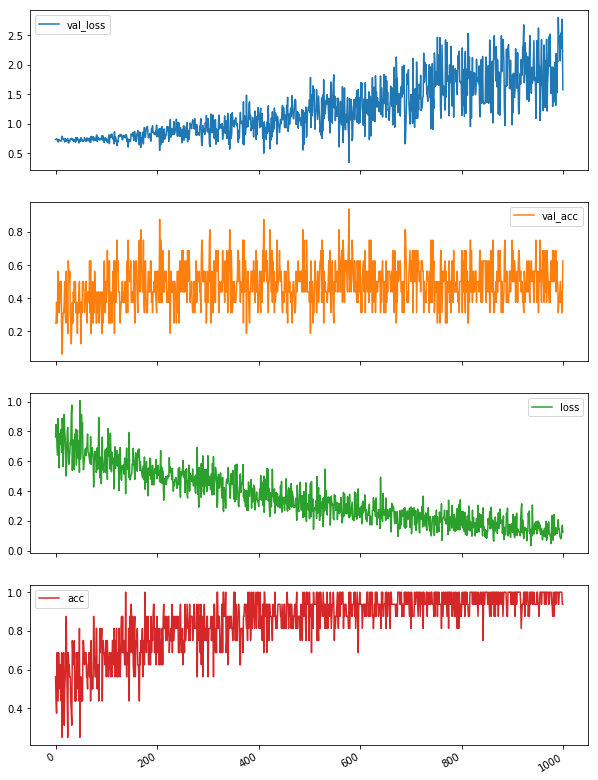

In [161]:
df_hist = pd.DataFrame(hist.history)
df_hist.plot(subplots=True, figsize=(10,15))

<Figure size 2160x2160 with 0 Axes>

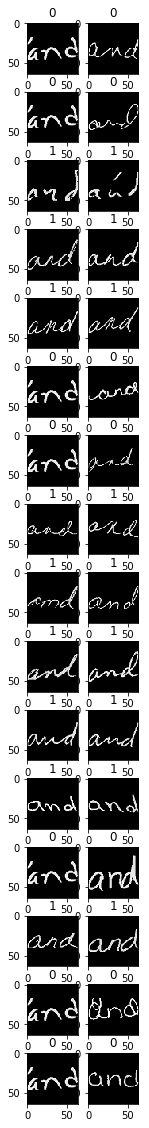

In [163]:
fig = plt.figure(figsize=(30,30))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
f,ax=plt.subplots(batchsize,2, figsize=(2,20))
# f.set_figwidth(30)
# f.tight_layout()
# f.set_we
for i in range(batchsize):
#     display(np.argmax(y[i]))
    ax[i][0].imshow(x[0][i])
    ax[i][1].imshow(x[1][i])
    ax[i][0].set_title(np.argmax(y[i]))
    ax[i][1].set_title(np.argmax(y[i]))

In [147]:
image = x[0][4]
# image.shape
len(image[image!=0])/len(image[image>=0])

0.143798828125